Render a map wallpaper from a open data. Map data downloaded from openstreetmap & https://julkinen.traficom.fi/oskari/?lang=fi

In [1]:
%%sh
pip install osmnx pyproj
sudo apt-get update
sudo apt-get install -y graphicsmagick

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
graphicsmagick is already the newest version (1.4+really1.3.35-1).
0 upgraded, 0 newly installed, 0 to remove and 55 not upgraded.


In [2]:
from datetime import datetime
import itertools
import math
from pathlib import Path
import pickle
import hashlib
import geopandas as gp
import numpy as np
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
import pyproj
from dataclasses import dataclass
from PIL import Image

ox.config(use_cache=True, log_console=True)

epsg_3067 = 'epsg:3067'
epsg_4326 = 'epsg:4326'

@dataclass(frozen=True)
class BBox:
    w: float
    s: float
    e: float
    n: float
    crs: str

    @property
    def wsen(self):
        return self.w, self.s, self.e, self.n

    @property
    def nsew(self):
        return self.n, self.s, self.e, self.w
    
    def to_crs(self, to_crs: str) -> 'BBox':
        t = Transformer.from_crs(self.crs, to_crs, always_xy=True)
        w, s, e, n = t.transform_bounds(*self.wsen, densify_pts=21)
        return BBox(w=w, s=s, e=e, n=n, crs=to_crs)
    
    def to_tiles(self, count_x: int, count_y: int):
        xv = np.linspace(self.w, self.e, count_x+1)
        yv = np.linspace(self.s, self.n, count_x+1)
        # reverse y to order the tiles in order which is compatible with 'gm montage'
        for y in reversed(range(count_y)):
            for x in range(count_x):
                yield (x, y), BBox(w=xv[x], e=xv[x+1], s=yv[y], n=yv[y+1], crs=self.crs)

    def grow(self, m: float) -> 'BBox':
        w = self.e - self.w
        h = self.n - self.s
        dw = w*m
        dh = h=m
        return BBox(w=self.w-dw, s=self.s-dh, e=self.e+dw, n=self.n+dh, crs=self.crs)

def cache(f):
    cache_dir = Path('func_cache')
    def inner(*args, **kwargs):
        key = hashlib.sha256(repr((args, kwargs)).encode('utf8')).hexdigest()[:24]
        cache_file = cache_dir / f'{f.__module__}.{f.__name__}_{key}.pickle'
        
        if cache_file.exists():
            with cache_file.open('rb') as fh:
                return pickle.load(fh)
        
        res = f(*args, **kwargs)
        
        cache_dir.mkdir(parents=True, exist_ok=True)
        with cache_file.open('wb') as fh:
            pickle.dump(res, fh)

        return res
    return inner

def graph_from_bbox(*args, to_crs=None, **kwargs):
    G = ox.graph_from_bbox(*bbox.to_crs('epsg:4326').nsew, **kwargs)
    if to_crs:
        return ox.project_graph(G, to_crs=to_crs)
    return G

def gdf_from_bbox(bbox: BBox, *args, to_crs=None, **kwargs):
    G = ox.graph_from_bbox(*bbox.to_crs('epsg:4326').nsew, *args, **kwargs)
    gdf = ox.graph_to_gdfs(G, nodes=False)
    if to_crs:
        return ox.project_gdf(gdf, to_crs)
    return gdf

def geometries_from_bbox(bbox: BBox, *args, to_crs=None, **kwargs):
    gdf = ox.geometries_from_bbox(*bbox.to_crs('epsg:4326').nsew, *args, **kwargs)
    if to_crs:
        return ox.project_gdf(gdf, to_crs)
    return gdf

def read_file(file, bbox=None, to_crs=None):
    if isinstance(bbox, BBox):
        bb = bbox.wsen
    else:
        bb = None
    gdf = gp.read_file(file, bbox=bb)
    if to_crs:
        return ox.project_gdf(gdf, to_crs)
    return gdf

def get_canvas(*, figsize, dpi, bbox, bgcolor, crs, show_axis=False):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi, facecolor=bgcolor, frameon=False)
    ax.set_facecolor(bgcolor)

    if isinstance(bbox, gp.GeoDataFrame):
        west, south, east, north = bbox.total_bounds
    else:
        north, south, east, west = bbox.to_crs(crs).nsew
    ax.set_ylim((south, north))
    ax.set_xlim((west, east))

    if not show_axis:
        # set margins to zero, point ticks inward, turn off ax border and x/y axis
        # so there is no space around the plot
        ax.margins(0)
        ax.tick_params(which="both", direction="in")
        for s in ax.spines.values():
            s.set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    # set aspect ratio
    if ox.projection.is_projected(crs):
        # if projected, make equal aspect ratio
        ax.set_aspect("equal")
    else:
        # if not projected, conform aspect ratio to not stretch plot
        cos_lat = np.cos((south + north) / 2 / 180 * np.pi)
        ax.set_aspect(1 / cos_lat)

    return fig, ax

def runtime(f, tmpl='[{}] {fname}()'):
    def inner(*args, **kwargs):
        t0 = datetime.now()
        res = f(*args, **kwargs)
        t1 = datetime.now()
        print(tmpl.format(t1-t0, fname=f.__name__))
        return res
    return inner

transparent = '#00000000'

/opt/conda/lib/python3.9/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [3]:
bbox = BBox(n=60.65, s=59.9, e=26.15, w=24.2, crs=epsg_4326).to_crs(epsg_3067)

In [4]:
%%time

roads_gdf = cache(gdf_from_bbox)(bbox, network_type='all_private', simplify=True, to_crs=epsg_3067)
rail_gdf = cache(gdf_from_bbox)(bbox, custom_filter='["railway"~"rail|subway"]', simplify=True, to_crs=epsg_3067)
aeroway_gdf = cache(gdf_from_bbox)(bbox, custom_filter='["aeroway"~"taxiway|runway"]', simplify=True, to_crs=epsg_3067)
coastline_gdf = cache(geometries_from_bbox)(bbox, tags={'natural':['water', 'coastline']}, to_crs=epsg_3067)
depth_gdf = cache(read_file)('DepthContour_L_0/DepthContour_LLine.shp', bbox=bbox)

CPU times: user 23.1 s, sys: 1.2 s, total: 24.3 s
Wall time: 24.7 s


In [5]:
def plot_wallpaper(
        bbox: BBox, *, figsize, dpi=100,
        roads_gdf, rail_gdf, aeroway_gdf, coastline_gdf, depth_gdf,
        bgcolor=transparent, show=False):
    def p(gdf, **kwargs):
        if len(gdf):
            gdf.plot(**kwargs)
    
    c = itertools.count(1)
    
    fig, ax = get_canvas(bbox=bbox, figsize=figsize, dpi=dpi, bgcolor=bgcolor, crs=bbox.crs)

    coastline = coastline_gdf[coastline_gdf["geometry"].type.isin({'Polygon', 'MultiPolygon', 'LineString'})]
    
    light_road_selector = roads_gdf['highway'].isin({'path', 'cycleway', 'footway', 'steps', 'pedestrian', 'footway'})
    motorway_selector = roads_gdf['highway'].isin({'motorway', 'trunk', 'primary'})
    light_roads = roads_gdf[light_road_selector]
    motorway_roads = roads_gdf[motorway_selector]
    heavy_roads = roads_gdf[~(light_road_selector | motorway_selector)]
    
    gdf_bb = bbox.grow(0.1)
    bb_slice = slice(gdf_bb.w, gdf_bb.e), slice(gdf_bb.s, gdf_bb.n)
    p(depth_gdf.cx[bb_slice], ax=ax, facecolor=transparent, edgecolor='#444', lw=0.8, zorder=next(c))
    p(coastline.cx[bb_slice], ax=ax, facecolor=transparent, edgecolor='k', lw=1.1, zorder=next(c))
    p(aeroway_gdf.cx[bb_slice], ax=ax, facecolor=transparent, edgecolor='#444', lw=2, zorder=next(c))
    
    p(light_roads.cx[bb_slice], ax=ax, facecolor=transparent, edgecolor='k', lw=0.3, zorder=next(c))
    p(heavy_roads.cx[bb_slice], ax=ax, facecolor=transparent, edgecolor='k', lw=0.6, zorder=next(c))
    p(motorway_roads.cx[bb_slice], ax=ax, facecolor=transparent, edgecolor='k', lw=0.9, zorder=next(c))

    p(rail_gdf.cx[bb_slice], ax=ax, facecolor=transparent, edgecolor='k', lw=0.4, zorder=next(c))

    fig.canvas.draw()
    fig.canvas.flush_events()
    if show:
        plt.show()
    plt.close()
    return fig

[0:02:32.573089] plot_wallpaper()
CPU times: user 2min 30s, sys: 786 ms, total: 2min 31s
Wall time: 2min 32s


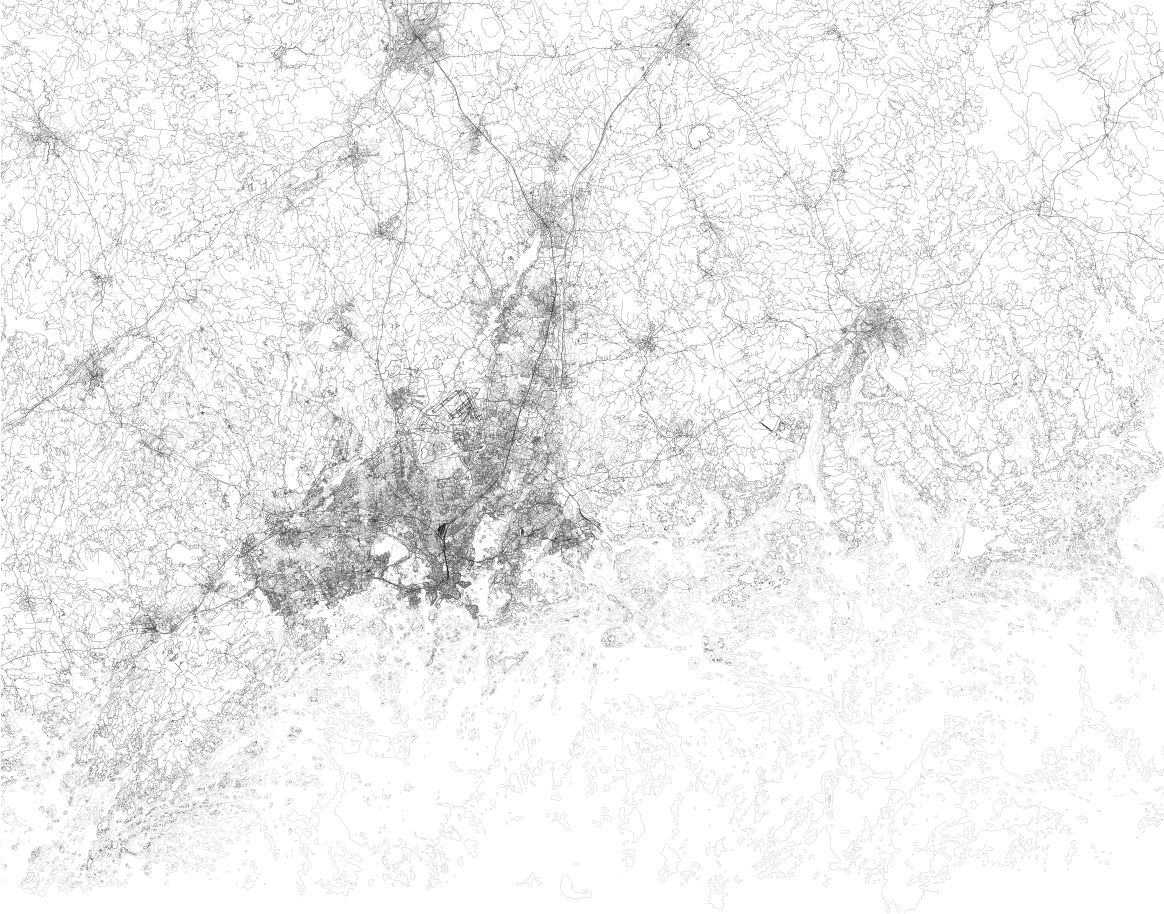

In [6]:
%%time
runtime(plot_wallpaper)(
    bbox,
    figsize=(150,150),
    dpi=10,
    show=False,
    roads_gdf=roads_gdf,
    rail_gdf=rail_gdf,
    aeroway_gdf=aeroway_gdf,
    coastline_gdf=coastline_gdf,
    depth_gdf=depth_gdf,
)

In [7]:
%%time

t_start = datetime.now()
for n, (xy, bb) in enumerate(bbox.to_tiles(4, 4)):
    fig = runtime(plot_wallpaper, f'[{datetime.now()-t_start}/{{}}] {{fname}}({n}/{xy})')(
        bb,
        figsize=(40, 40),
        roads_gdf=roads_gdf,
        rail_gdf=rail_gdf,
        aeroway_gdf=aeroway_gdf,
        coastline_gdf=coastline_gdf,
        depth_gdf=depth_gdf,
    )
    for dpi in [400, 450]:
        runtime(fig.savefig, f'[{datetime.now()-t_start}/{{}}] {{fname}}({dpi=})')(f'pkseutu/tile/tile_dpi={dpi},{n:03d}.png', dpi=dpi, bbox_inches='tight', pad_inches=0)

[0:00:00.000270/0:00:14.018619] plot_wallpaper(0/(0, 3))
[0:00:14.019033/0:00:20.467997] savefig(dpi=400)
[0:00:34.487134/0:00:24.615815] savefig(dpi=450)
[0:00:59.103090/0:00:19.450575] plot_wallpaper(1/(1, 3))
[0:01:18.554029/0:00:22.185710] savefig(dpi=400)
[0:01:40.740064/0:00:27.063019] savefig(dpi=450)
[0:02:07.804391/0:00:14.788694] plot_wallpaper(2/(2, 3))
[0:02:22.593281/0:00:20.034647] savefig(dpi=400)
[0:02:42.628265/0:00:24.084782] savefig(dpi=450)
[0:03:06.713195/0:00:12.337613] plot_wallpaper(3/(3, 3))
[0:03:19.050958/0:00:18.718928] savefig(dpi=400)
[0:03:37.769999/0:00:23.333981] savefig(dpi=450)
[0:04:01.104339/0:00:17.340560] plot_wallpaper(4/(0, 2))
[0:04:18.445092/0:00:21.833735] savefig(dpi=400)
[0:04:40.278958/0:00:26.721591] savefig(dpi=450)
[0:05:07.000690/0:00:51.774877] plot_wallpaper(5/(1, 2))
[0:05:58.776237/0:00:26.803247] savefig(dpi=400)
[0:06:25.583636/0:00:32.936626] savefig(dpi=450)
[0:06:58.521271/0:00:21.650794] plot_wallpaper(6/(2, 2))
[0:07:20.1744

In [8]:
%%time
%%sh

# join the tiles together

gm montage pkseutu/tile/tile_dpi=450,0*.png -tile 4x4 -background white -geometry +0+0 -depth 8 pkseutu_dpi=450.png
gm identify pkseutu_dpi=450.png

pkseutu_dpi=450.png PNG 55800x43812+0+0 DirectClass 8-bit 284.1Mi 0.000u 0m:0.000002s
CPU times: user 81.7 ms, sys: 428 ms, total: 510 ms
Wall time: 23min 24s
